<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/On_Going_Research_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down. 

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model. 
- False positives (FP) are detections in a wind turbine where there is no failure. 

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [1]:
!pip install nb-black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s eta 0:00:00
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5298 sha256=5768059a8b293d5ab2bcb72d3dee60bd94f9bb24694a1d99e893b37453aaeaaf
  Stored in directory: /root/.cache/pip/wheels/a6/5e/1e/a15614d6ea220d070043db3b650d73a8b4938aefd520496c11
Successfully built nb-black


In [2]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To use statistical functions
import scipy.stats as stats

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

## Loading Data

In [16]:
# Loading the dataset
train = pd.read_csv('https://raw.githubusercontent.com/RafsanJany-44/Machine-School/main/datasets/FiveStageSleep_Small_dataset.csv')

train = train.loc[:,train.columns != "Unnamed: 0"]
train = train.loc[:,train.columns != "Epoch"]
train = train.loc[:,train.columns != "Subject"]


<IPython.core.display.Javascript object>

In [17]:
# Checking the number of rows and columns in the data
train.shape

(5000, 76)

<IPython.core.display.Javascript object>

- There are 40,000 rows and 41 attributes (including the predictor) in the dataset

## Data Overview

In [18]:
data = train.copy()

<IPython.core.display.Javascript object>

In [19]:
# let's view the first 5 rows of the data
data.head()

,Sleep Stage,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,PeakF_Beta_F4,MeanP_Theta_F4,MedianF_Theta_F4,MeanF_Theta_F4,Spectral Edge_Theta_F4,PeakF_Theta_F4,MeanP_Delta_F4,MedianF_Delta_F4,MeanF_Delta_F4,Spectral Edge_Delta_F4,PeakF_Delta_F4,MeanP_Gamma_F4,MedianF_Gamma_F4,MeanF_Gamma_F4,Spectral Edge_Gamma_F4,PeakF_Gamma_F4,MeanP_Alpha_C4,MedianF_Alpha_C4,MeanF_Alpha_C4,Spectral Edge_Alpha_C4,PeakF_Alpha_C4,MeanP_Beta_C4,MedianF_Beta_C4,MeanF_Beta_C4,Spectral Edge_Beta_C4,PeakF_Beta_C4,MeanP_Theta_C4,MedianF_Theta_C4,MeanF_Theta_C4,Spectral Edge_Theta_C4,PeakF_Theta_C4,MeanP_Delta_C4,MedianF_Delta_C4,MeanF_Delta_C4,Spectral Edge_Delta_C4,PeakF_Delta_C4,MeanP_Gamma_C4,MedianF_Gamma_C4,MeanF_Gamma_C4,Spectral Edge_Gamma_C4,PeakF_Gamma_C4,MeanP_Alpha_O2,MedianF_Alpha_O2,MeanF_Alpha_O2,Spectral Edge_Alpha_O2,PeakF_Alpha_O2,MeanP_Beta_O2,MedianF_Beta_O2,MeanF_Beta_O2,Spectral Edge_Beta_O2,PeakF_Beta_O2,MeanP_Theta_O2,MedianF_Theta_O2,MeanF_Theta_O2,Spectral Edge_Theta_O2,PeakF_Theta_O2,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
0,W,0.001,8.741,18.482,17.483,8.242,0.001,19.731,29.846,33.842,15.984,0.001,4.246,10.490,7.992,2.622,0.011,1.124,4.745,2.622,1.124,0.000,36.215,43.083,50.076,49.951,0.000,10.115,19.356,18.482,10.490,0.001,19.980,28.972,33.218,16.859,0.001,5.245,12.238,9.865,3.871,0.004,1.124,5.495,2.747,0.624,0.000,34.716,41.584,49.951,49.951,0.000,10.989,20.730,20.480,10.490,0.001,21.104,29.721,34.217,21.229,0.000,4.496,13.487,10.740,2.248,0.007,0.749,3.871,1.998,0.874,0.000,35.216,42.209,49.951,49.951
1,W,0.000,10.240,17.483,16.859,10.615,0.001,17.233,26.349,29.346,19.606,0.001,4.371,12.363,9.990,2.872,0.005,0.874,4.496,2.622,0.749,0.000,34.966,46.580,49.951,49.951,0.000,10.365,17.733,17.358,10.115,0.001,17.358,26.349,28.472,17.358,0.000,5.744,12.738,10.740,3.621,0.002,0.999,5.869,2.872,0.749,0.000,31.344,40.835,49.951,49.951,0.000,10.615,18.232,17.858,10.615,0.000,17.982,27.223,30.970,19.481,0.000,5.869,13.612,11.239,2.997,0.007,0.500,3.746,1.249,0.500,0.000,34.341,43.333,49.951,49.951
2,W,0.000,9.740,17.982,17.483,8.741,0.000,17.608,25.475,28.222,18.732,0.001,4.995,12.113,9.366,2.997,0.010,0.624,4.371,1.748,0.624,0.000,34.341,49.202,49.951,49.951,0.000,10.365,18.107,17.733,9.116,0.000,17.608,24.851,26.849,14.236,0.000,5.620,12.987,10.490,2.997,0.003,0.749,5.744,2.622,0.375,0.000,29.596,40.835,49.951,49.951,0.000,10.740,18.107,17.858,10.864,0.000,17.733,25.475,28.472,20.730,0.000,5.744,13.362,11.114,5.120,0.002,0.624,5.245,2.123,0.624,0.000,34.591,45.955,49.951,49.951
3,W,0.000,10.115,17.608,17.108,9.616,0.000,17.358,26.474,28.722,16.359,0.000,5.744,12.613,10.365,2.123,0.002,0.999,5.869,2.622,0.624,0.000,32.968,46.455,49.951,49.951,0.000,10.115,18.357,17.858,10.240,0.001,18.857,26.349,28.098,16.359,0.000,5.994,12.738,10.490,5.869,0.001,1.124,6.494,3.122,0.749,0.000,28.472,39.212,49.826,49.951,0.000,10.365,18.357,18.107,10.240,0.000,18.232,26.724,28.597,16.359,0.000,6.119,13.237,10.989,3.621,0.001,0.874,6.619,3.122,0.624,0.000,32.468,43.957,49.951,49.951
4,W,0.000,9.740,17.608,17.233,8.117,0.000,17.233,25.850,28.098,17.608,0.001,4.745,12.238,9.491,2.997,0.004,0.749,4.995,2.622,0.500,0.000,34.217,49.577,49.951,49.951,0.000,10.240,17.733,17.483,10.365,0.000,17.358,26.100,28.098,17.608,0.000,5.744,13.112,10.365,5.744,0.001,0.874,6.119,3.122,0.624,0.000,29.971,39.711,49.826,49.951,0.000,10.490,18.357,17.982,10.365,0.000,18.232,25.975,28.722,20.480,0.000,5.869,13.237,10.989,2.997,0.002,0.500,5.744,2.248,0.500,0.000,33.592,44.831,49.951,49.951


<IPython.core.display.Javascript object>

In [20]:
# let's view the last 5 rows of the data
data.tail()

,Sleep Stage,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,PeakF_Beta_F4,MeanP_Theta_F4,MedianF_Theta_F4,MeanF_Theta_F4,Spectral Edge_Theta_F4,PeakF_Theta_F4,MeanP_Delta_F4,MedianF_Delta_F4,MeanF_Delta_F4,Spectral Edge_Delta_F4,PeakF_Delta_F4,MeanP_Gamma_F4,MedianF_Gamma_F4,MeanF_Gamma_F4,Spectral Edge_Gamma_F4,PeakF_Gamma_F4,MeanP_Alpha_C4,MedianF_Alpha_C4,MeanF_Alpha_C4,Spectral Edge_Alpha_C4,PeakF_Alpha_C4,MeanP_Beta_C4,MedianF_Beta_C4,MeanF_Beta_C4,Spectral Edge_Beta_C4,PeakF_Beta_C4,MeanP_Theta_C4,MedianF_Theta_C4,MeanF_Theta_C4,Spectral Edge_Theta_C4,PeakF_Theta_C4,MeanP_Delta_C4,MedianF_Delta_C4,MeanF_Delta_C4,Spectral Edge_Delta_C4,PeakF_Delta_C4,MeanP_Gamma_C4,MedianF_Gamma_C4,MeanF_Gamma_C4,Spectral Edge_Gamma_C4,PeakF_Gamma_C4,MeanP_Alpha_O2,MedianF_Alpha_O2,MeanF_Alpha_O2,Spectral Edge_Alpha_O2,PeakF_Alpha_O2,MeanP_Beta_O2,MedianF_Beta_O2,MeanF_Beta_O2,Spectral Edge_Beta_O2,PeakF_Beta_O2,MeanP_Theta_O2,MedianF_Theta_O2,MeanF_Theta_O2,Spectral Edge_Theta_O2,PeakF_Theta_O2,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
4995,N2,0.001,9.616,13.737,13.487,11.114,0.000,12.363,21.229,21.604,11.114,0.001,5.495,11.364,9.990,4.246,0.004,1.249,6.119,2.997,0.874,0.000,24.226,34.966,43.333,49.951,0.001,8.991,13.986,13.487,6.494,0.000,13.112,21.354,21.979,13.487,0.001,5.120,11.114,9.116,4.371,0.004,1.124,5.869,2.997,0.874,0.000,29.596,49.826,49.951,49.951,0.000,7.867,13.737,12.987,6.868,0.000,12.738,21.604,21.979,12.987,0.001,5.994,10.240,8.741,5.994,0.002,1.374,6.868,4.121,0.500,0.000,26.724,37.089,45.331,49.951
4996,N2,0.001,8.617,13.612,13.237,7.493,0.001,12.488,20.230,20.480,13.362,0.001,5.744,11.364,9.366,4.371,0.006,1.249,5.994,2.747,0.874,0.000,23.102,34.217,42.084,49.951,0.001,9.116,13.986,13.737,13.362,0.001,13.237,19.606,20.230,13.362,0.001,4.745,11.739,8.991,4.371,0.009,0.999,5.245,2.622,0.749,0.000,27.348,49.826,49.951,49.951,0.000,8.242,13.986,13.487,6.619,0.000,12.987,21.104,21.479,13.612,0.001,5.495,10.615,8.617,4.496,0.003,1.249,6.494,3.871,0.500,0.000,25.350,37.214,45.331,49.951
4997,N3,0.001,9.740,13.487,12.987,12.113,0.001,12.113,19.980,20.230,12.113,0.001,5.370,11.988,10.490,3.122,0.017,0.624,4.620,1.748,0.624,0.000,22.103,33.592,41.709,49.951,0.001,8.991,14.236,13.612,8.741,0.000,12.987,21.229,21.729,13.237,0.001,4.496,11.489,8.991,3.871,0.007,0.749,5.370,3.122,0.624,0.000,27.598,49.826,49.951,49.951,0.001,8.242,14.236,13.362,6.868,0.000,12.738,21.229,21.604,12.363,0.001,5.744,10.864,8.866,6.369,0.003,0.999,6.494,3.122,0.375,0.000,24.726,36.964,44.956,49.951
4998,N3,0.001,8.242,13.737,12.987,9.990,0.000,12.363,21.854,22.103,9.990,0.001,5.120,10.240,8.617,5.869,0.010,0.999,5.120,2.373,0.874,0.000,25.350,36.090,45.580,49.951,0.001,8.242,14.236,13.487,8.242,0.000,13.237,21.354,21.729,13.362,0.001,4.246,10.240,8.117,3.746,0.011,0.999,4.995,2.622,0.874,0.000,31.469,49.826,49.951,49.951,0.000,8.492,14.111,13.237,7.243,0.000,12.613,21.229,21.729,10.365,0.001,5.495,10.490,8.991,6.244,0.003,0.874,6.244,3.247,0.749,0.000,25.975,37.588,45.955,49.951
4999,N3,0.001,8.741,13.737,13.112,11.114,0.000,12.238,20.730,20.980,11.114,0.001,5.120,11.114,8.866,4.745,0.006,1.374,5.744,3.122,1.623,0.000,23.602,34.716,42.958,49.951,0.001,8.617,14.236,13.737,7.992,0.000,13.237,20.230,20.730,13.362,0.001,4.870,10.989,8.741,4.745,0.007,1.374,5.495,2.872,1.623,0.000,28.847,49.826,49.951,49.951,0.000,8.242,14.611,13.986,8.117,0.000,13.362,21.229,21.729,13.362,0.001,5.245,10.740,8.617,4.121,0.002,1.374,6.619,3.996,0.624,0.000,24.726,37.463,45.955,49.951


<IPython.core.display.Javascript object>

- The attributes are ciphered

In [21]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 76 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sleep Stage             5000 non-null   object 
 1   MeanP_Alpha_F4          5000 non-null   float64
 2   MedianF_Alpha_F4        5000 non-null   float64
 3   MeanF_Alpha_F4          5000 non-null   float64
 4   Spectral Edge_Alpha_F4  5000 non-null   float64
 5   PeakF_Alpha_F4          5000 non-null   float64
 6   MeanP_Beta_F4           5000 non-null   float64
 7   MedianF_Beta_F4         5000 non-null   float64
 8   MeanF_Beta_F4           5000 non-null   float64
 9   Spectral Edge_Beta_F4   5000 non-null   float64
 10  PeakF_Beta_F4           5000 non-null   float64
 11  MeanP_Theta_F4          5000 non-null   float64
 12  MedianF_Theta_F4        5000 non-null   float64
 13  MeanF_Theta_F4          5000 non-null   float64
 14  Spectral Edge_Theta_F4  5000 non-null   

<IPython.core.display.Javascript object>

- All attributes except for the predictor "Target" are of float type
- There are 46 missing values for attribute "V1" and 39 missing values for attribute "V2"

In [22]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

- There are no duplicate values in the dataset

In [23]:
# let's check for number of unique values in each column
data.nunique()

Sleep Stage                 5
MeanP_Alpha_F4            282
MedianF_Alpha_F4           69
MeanF_Alpha_F4            117
Spectral Edge_Alpha_F4    130
                         ... 
MeanP_Gamma_O2            994
MedianF_Gamma_O2          259
MeanF_Gamma_O2            135
Spectral Edge_Gamma_O2    109
PeakF_Gamma_O2            267
Length: 76, dtype: int64

<IPython.core.display.Javascript object>

- All attributes except "Target" have all unique values

In [24]:
# let's view the statistical summary of the numerical columns in the data
data.describe()

,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,PeakF_Beta_F4,MeanP_Theta_F4,MedianF_Theta_F4,MeanF_Theta_F4,Spectral Edge_Theta_F4,PeakF_Theta_F4,MeanP_Delta_F4,MedianF_Delta_F4,MeanF_Delta_F4,Spectral Edge_Delta_F4,PeakF_Delta_F4,MeanP_Gamma_F4,MedianF_Gamma_F4,MeanF_Gamma_F4,Spectral Edge_Gamma_F4,PeakF_Gamma_F4,MeanP_Alpha_C4,MedianF_Alpha_C4,MeanF_Alpha_C4,Spectral Edge_Alpha_C4,PeakF_Alpha_C4,MeanP_Beta_C4,MedianF_Beta_C4,MeanF_Beta_C4,Spectral Edge_Beta_C4,PeakF_Beta_C4,MeanP_Theta_C4,MedianF_Theta_C4,MeanF_Theta_C4,Spectral Edge_Theta_C4,PeakF_Theta_C4,MeanP_Delta_C4,MedianF_Delta_C4,MeanF_Delta_C4,Spectral Edge_Delta_C4,PeakF_Delta_C4,MeanP_Gamma_C4,MedianF_Gamma_C4,MeanF_Gamma_C4,Spectral Edge_Gamma_C4,PeakF_Gamma_C4,MeanP_Alpha_O2,MedianF_Alpha_O2,MeanF_Alpha_O2,Spectral Edge_Alpha_O2,PeakF_Alpha_O2,MeanP_Beta_O2,MedianF_Beta_O2,MeanF_Beta_O2,Spectral Edge_Beta_O2,PeakF_Beta_O2,MeanP_Theta_O2,MedianF_Theta_O2,MeanF_Theta_O2,Spectral Edge_Theta_O2,PeakF_Theta_O2,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
count,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.001,9.161,15.649,14.838,8.291,0.001,14.956,25.202,27.876,21.577,0.001,5.149,11.194,9.296,4.614,0.015,1.037,5.492,2.714,0.831,0.000,34.432,42.488,48.249,42.535,0.001,9.141,15.760,15.085,10.402,0.001,19.612,27.749,29.060,22.435,0.001,5.212,11.246,9.275,4.659,0.013,1.159,5.745,3.011,0.888,0.000,34.227,42.743,47.548,41.031,0.000,9.040,15.877,15.059,8.275,0.001,15.571,25.591,28.001,21.601,0.001,5.582,11.214,9.377,5.095,0.016,0.982,6.097,3.046,0.748,0.000,35.310,43.450,48.536,42.726
std,0.001,1.016,2.328,2.501,1.822,0.001,3.284,6.005,8.435,15.881,0.001,0.865,1.196,1.143,1.523,0.046,0.300,1.084,0.712,0.365,0.000,10.007,5.938,3.088,12.494,0.001,1.073,2.349,2.888,9.051,0.001,12.264,10.561,10.693,16.537,0.001,0.916,1.270,1.205,1.536,0.045,0.359,1.105,0.756,0.416,0.001,10.859,6.682,3.643,13.635,0.001,1.159,2.088,2.346,2.573,0.001,3.935,5.503,6.922,15.694,0.002,0.992,1.389,1.305,1.634,0.068,0.289,1.315,0.942,0.277,0.001,9.151,5.609,2.297,11.970
min,0.000,5.120,11.114,10.115,2.872,0.000,8.991,17.108,16.234,6.244,0.000,2.373,6.743,4.745,0.749,0.000,0.125,1.748,0.624,0.125,0.000,17.358,30.970,35.840,7.493,0.000,5.620,11.239,9.990,1.249,0.000,8.617,16.109,15.110,6.369,0.000,1.873,8.117,5.120,0.749,0.000,0.125,1.748,0.500,0.125,0.000,14.736,29.221,34.841,7.118,0.000,6.119,10.864,10.365,1.249,0.000,9.116,15.984,15.735,5.744,0.000,1.623,8.117,5.120,0.500,0.000,0.125,1.499,0.500,0.125,0.000,15.984,32.343,37.713,6.244
25%,0.000,8.617,14.111,13.237,6.993,0.000,12.488,21.229,21.729,10.615,0.000,4.620,10.490,8.617,3.621,0.002,0.874,4.745,2.248,0.624,0.000,25.475,37.463,46.455,35.216,0.000,8.492,14.236,13.487,6.993,0.000,12.987,21.104,21.604,10.864,0.000,4.620,10.365,8.492,3.621,0.001,0.874,5.120,2.622,0.624,0.000,24.476,36.464,45.331,31.313,0.000,8.242,14.611,13.737,6.868,0.000,13.487,22.478,23.227,11.364,0.000,5.120,10.365,8.617,3.871,0.001,0.874,5.620,2.622,0.500,0.000,27.598,38.587,47.579,35.091
50%,0.000,9.116,15.360,14.486,7.742,0.000,14.486,23.602,25.225,13.237,0.001,5.120,10.989,9.241,4.121,0.005,0.999,5.495,2.747,0.749,0.000,32.219

<IPython.core.display.Javascript object>

- The spread of attributes will be explored further (univariate analysis)

## Univariate Analysis

In [ ]:
cols = data.columns.tolist()

plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.boxplot(data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- There are positive and negative outliers for all attributes "V1" to "V40". The scale of attributes are more or less the same (somewhere between -20 to +20). Since not much is known about the attributes, the outliers will not be treated and are assumed to be real data trends

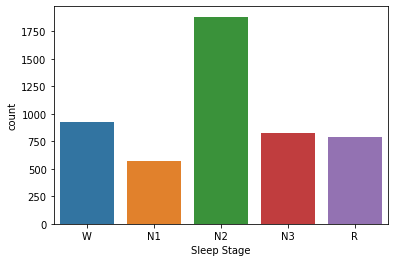

N2    1884
W      926
N3     827
R      793
N1     570
Name: Sleep Stage, dtype: int64

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(data["Sleep Stage"])
plt.show()
data["Sleep Stage"].value_counts()

- "Target" class is imbalanced with 37813 or 94.53% "No failures (i.e., 0)" and 2187 or 5.47% "Failures (i.e., 1)"

## Data Pre-processing

In [27]:
# Split data
df = data.copy()

X = df.drop(["Sleep Stage"], axis=1)
y = df["Sleep Stage"]

<IPython.core.display.Javascript object>

In [28]:
# Splitting data into training and validation sets:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)

(3500, 75) (1500, 75)


<IPython.core.display.Javascript object>

- There are 28000 rows in the training and 12000 rows in the validation sets

In [29]:
y_train.value_counts()

N2    1319
W      648
N3     579
R      555
N1     399
Name: Sleep Stage, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
y_val.value_counts()

N2    565
W     278
N3    248
R     238
N1    171
Name: Sleep Stage, dtype: int64

<IPython.core.display.Javascript object>

- Stratify has maintained a distribution of 94.53% "No failures" or "0" and 5.47% "Failures" or "1" in both the test and validation splits

### Missing-Value Treatment

* We will use median to impute missing values in "V1" and "V2" columns. 

In [31]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_train)

X_train = impute.transform(X_train)
X_val = imputer.transform(X_val)

<IPython.core.display.Javascript object>

## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure 
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost
* The cost associated with any model = (TPX15000) + (FPX5000) + (FNX40000)
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN)X15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

### Let's create two functions to calculate different metrics and confusion matrix

In [32]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (
        TP + FN
    ) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = (
        Min_Cost / Cost
    )  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [33]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

###  Defining scorer to be used for hyperparameter tuning

- Every prediction of a classification model will be either a TP, FP, FN or TN
- For this classification problem, we need to reduce the maintenance cost, which can be reiterated as:
  - Maximize (minimum possible maintenance cost/maintenance cost)

In [34]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):
    """
    We want the model to optimize the maintenance cost and reduce it to the lowest possible value.
    The lowest possible maintenance cost will be achieved when each sample is predicted correctly.

    In such a scenario, the maintenance cost will be the total number of failures times the maintenance cost of replacing one generator,
    which is given by (TP + FN) * 40 (i.e., the actual positives*40).
    For any other scenario,
    the maintenance cost associated with the model will be given by (TP * 15 + FP * 5 + FN * 40).

    We will use the ratio of these two maintenance costs as the cost function for our model.
    The greater the ratio, the lower the associated maintenance cost and the better the model.
    """
    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# A value of .80 here, will represent that the minimum maintenance cost is 80% of the maintenance cost associated with the model.
# Since minimum maintenance cost is constant for any data, when minimum cost will become 100% of maintenance cost associated with the model
# Model will have give the least possible maintenance cost.


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Higher the values, the lower the maintenance cost

<IPython.core.display.Javascript object>

## Model Building with Original Training data

In [35]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.9208724629397074
dtree: 0.8554851527741485
Random forest: 0.9275196273213014
Bagging: 0.8991681099203452
Adaboost: 0.9016395232205436
GBM: 0.9245363126028796


ValueError: ignored

<IPython.core.display.Javascript object>

In [36]:
print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Minimum_Vs_Model_cost(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.9429718875502008
dtree: 1.0
Random forest: 1.0
Bagging: 0.9949443882709808
Adaboost: 0.9087099670757258
GBM: 0.9671396564600448


ValueError: ignored

<IPython.core.display.Javascript object>

In [37]:
print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = Minimum_Vs_Model_cost(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.9084888621312462
dtree: 0.8459250446162998
Random forest: 0.9114369501466275
Bagging: 0.8700854700854701
Adaboost: 0.897489539748954
GBM: 0.9043988269794722


ValueError: ignored

<IPython.core.display.Javascript object>

- The cross validation training performance scores (customized metric) are similar to the validation perfromance score. This indicates that the default algorithms on original dataset are able to generalize well
- There is a tendency for some models (decision tree, random forest, bagging and XGBoost) to overfit the training set; as the training performance score (customized metric) approaches 1

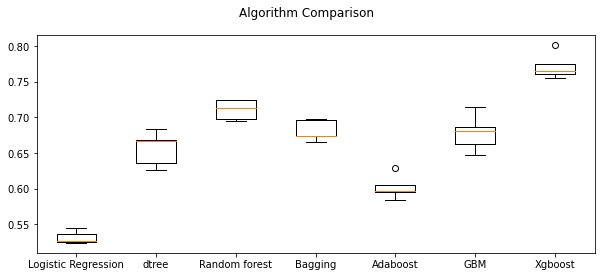

<IPython.core.display.Javascript object>

In [ ]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- XGBoost (~ 0.77) and Random Forest (~ 0.71) have the best average (& median) training cross validation scores (on the customized metric). This is closely followed by Bagging Classifier (~ 0.68)
- XGBoost and AdaBoost each have one outlier as can be observed from the boxplot
- The boxplot widths (spread of CV scores) is small for XGBoost, Random Forest and Bagging Classifier as well, indicating these are reliable models to choose for further optimization

## Model Building with Oversampled Training data


In [ ]:
print(
    "Before Oversampling, counts of label '1 (Failures)': {}".format(sum(y_train == 1))
)
print(
    "Before Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train == 0)
    )
)

Before Oversampling, counts of label '1 (Failures)': 1531
Before Oversampling, counts of label '0 (No failures)': 26469 



<IPython.core.display.Javascript object>

In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [ ]:
print(
    "After Oversampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_over == 1)
    )
)
print(
    "After Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_over == 0)
    )
)

After Oversampling, counts of label '1 (Failures)': 26469
After Oversampling, counts of label '0 (No failures)': 26469 



<IPython.core.display.Javascript object>

- To handle class imbalance in "Target" attribute, synthetic minority oversampling technique was employed to generate synthetic data points for minority class of importance (i.e, class "1" or No failures)
- After applying SMOTE, we have equal number of class "1" and calss "0" target outcomes 

In [ ]:
models_over = []  # Empty list to store all the models

# Appending models into the list

models_over.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models
score_over = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.7991885856657728
dtree: 0.935799411923789
Random forest: 0.9684099076356956
Bagging: 0.9567710595379042
Adaboost: 0.8302735716914681
GBM: 0.8698213334032019
Xgboost: 0.9735494688964318


<IPython.core.display.Javascript object>

In [ ]:
print("\n" "Training Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = Minimum_Vs_Model_cost(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.7997723770483548
dtree: 1.0
Random forest: 1.0
Bagging: 0.9976255088195387
Adaboost: 0.8345542254779346
GBM: 0.8726427535276275
Xgboost: 0.9979264062735635


<IPython.core.display.Javascript object>

In [ ]:
print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = Minimum_Vs_Model_cost(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.5025536261491318
dtree: 0.6377187297472456
Random forest: 0.802937576499388
Bagging: 0.7633824670287044
Adaboost: 0.5696092619392186
GBM: 0.7294292068198666
Xgboost: 0.8065573770491803


<IPython.core.display.Javascript object>

- The cross validation training performance scores (customized metric) are much higher than validation perfromance score. This indicates that the default algorithms on oversampled dataset are not able to generalize well
- It is likely that the algorithms are overfitting the noise in the training sets which explains the trends in the observed performance scores (cross validation training scores ~ training score >> validation score). This will be a concern taking these models to production

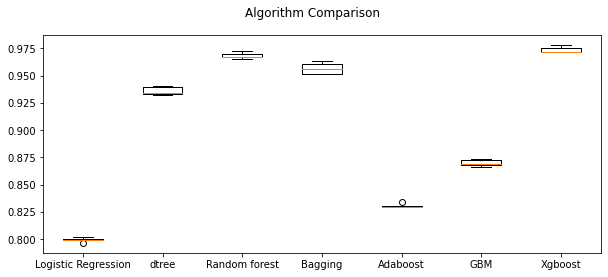

<IPython.core.display.Javascript object>

In [ ]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names)

plt.show()

- The average (& median) training cross validation scores on oversampled dataset has increased to match training performance scores across algorithms. This indicates potential overfitting of noise in the training datasets

## Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [ ]:
print(
    "After Undersampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_un == 1)
    )
)
print(
    "After Undersampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_un == 0)
    )
)

After Undersampling, counts of label '1 (Failures)': 1531
After Undersampling, counts of label '0 (No failures)': 1531 



<IPython.core.display.Javascript object>

- Another technique to handle class imbalance in "Target" attribute is random undersampling, wherein only random samples from the majority class are chosen for model building. While this helps in dealing with models potentially overfitting, it can often lead to poor performing models due to "loss of information" from not considering all datapoints available 
- After random undersampling, we again have equal number of class "1" and class "0" (and overall less number of datapoints for model building)

In [ ]:
models_un = []  # Empty list to store all the models

# Appending models into the list

models_un.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_un.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_un.append(("Random forest", RandomForestClassifier(random_state=1)))
models_un.append(("Bagging", BaggingClassifier(random_state=1)))
models_un.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_un.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_un.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_un = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models
score_un = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_un:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_un.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.7724863000214184
dtree: 0.7623582706765808
Random forest: 0.842602547619812
Bagging: 0.810537034879969
Adaboost: 0.7875970384722428
GBM: 0.8260845219126203
Xgboost: 0.8405650028470488


<IPython.core.display.Javascript object>

In [ ]:
print("\n" "Training Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = Minimum_Vs_Model_cost(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.772322179250042
dtree: 1.0
Random forest: 1.0
Bagging: 0.9624895222129086
Adaboost: 0.8197394253078708
GBM: 0.8726961808854266
Xgboost: 1.0


<IPython.core.display.Javascript object>

In [ ]:
print("\n" "Validation Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = Minimum_Vs_Model_cost(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.4932330827067669
dtree: 0.4738743077293523
Random forest: 0.7348767737117252
Bagging: 0.6691601496089765
Adaboost: 0.5512605042016807
GBM: 0.6762886597938145
Xgboost: 0.7440453686200378


<IPython.core.display.Javascript object>

- The performance score (customized metric) have dropped on the validation undersampled dataset than original dataset. This could be likely that the algorithms are overfitting the noise & underfitting the information in the undersampled datasets. This will again be a concern taking these models to production

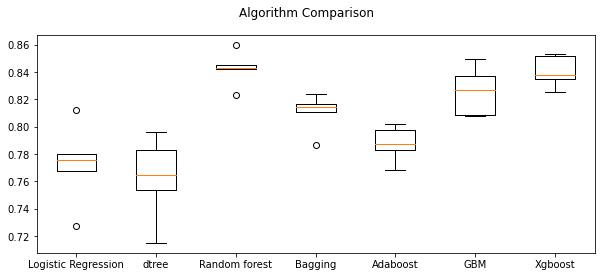

<IPython.core.display.Javascript object>

In [ ]:
# Plotting boxplots for CV scores of all models defined above

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_un)
ax.set_xticklabels(names)

plt.show()

- The algorithms are able to give better performance on the cross validation training scores on undersampled dataset in comparison to original dataset as can be seen from the boxplots. However, the issue is the lack of generalizatbility in carrying forth the performance to the validation set

## Model Selection

- Models built on original dataset have given generalized performance on cross validation training and validation sets unlike models built on oversampled or undersampled sets
- Mean cross validation scores on training sets are highest with XGBoost, Random Forest & Bagging Classifiers (~77, ~71 and ~68% respectively). These models will be tuned further to try to increase performance

## HyperparameterTuning 

In [ ]:
# defining model - XGBoost Hyperparameter Tuning
model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(150, 300, 50),
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scorer,
    cv=3,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.7997478671216852:


<IPython.core.display.Javascript object>

In [ ]:
# building model with best parameters
xgb_tuned = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=3,
    random_state=1,
    eval_metric="logloss",
)

# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=10, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [ ]:
# Calculating different metrics on training set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned, X_train, y_train
)
print("Training performance:")
xgboost_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,0.995,0.997,0.998


<IPython.core.display.Javascript object>

In [ ]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(xgb_tuned, X_val, y_val)
print("Validation performance:")
xgboost_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.991,0.877,0.962,0.917,0.821


<IPython.core.display.Javascript object>

- The best hyperparameters using RandomizedSearch CV for XGBoost model were found to be: subsample 0.9, scale_pos_weight 10, n_estimators 250, learning_rate 0.1 and gamma 3
- The average cross validation training performance score (customized metric) using the best parameter XGBoost model is 0.80. This is similar to the performance score (customized metric) on the validation set i.e., 0.82. This indicates the model may generalize with a performance score of ~0.80-0.82
- The model does however have a tendency to overfit the training set as can be observed from training performance (customized metric score of 0.998)

In [ ]:
# defining model - Random Forest Hyperparameter Tuning
model2 = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

param_grid2 = {
    "n_estimators": [150, 250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ["sqrt", "log2"],
    "max_samples": np.arange(0.2, 0.6, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_grid2,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv2.fit(X_train, y_train)
print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv2.best_params_, randomized_cv2.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} with CV score=0.6920650879825658:


<IPython.core.display.Javascript object>

In [ ]:
# building model with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf=1,
    max_samples=0.5000000000000001,
    max_features="sqrt",
    random_state=1,
)

# Fit the model on training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.5000000000000001,
                       n_estimators=250, random_state=1)

<IPython.core.display.Javascript object>

In [ ]:
# Calculating different metrics on training set
rf_random_train = model_performance_classification_sklearn(rf_tuned, X_train, y_train)
print("Training performance:")
rf_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.993,0.882,0.998,0.937,0.836


<IPython.core.display.Javascript object>

In [ ]:
# Calculating different metrics on validation set
rf_random_val = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print("Validation performance:")
rf_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.985,0.741,0.988,0.847,0.697


<IPython.core.display.Javascript object>

- The best hyperparameters using RandomizedSearch CV for Random forest model were found to be: n_estimators 250, min_sample_leaf 1, max_features 'sqrt', max_samples 0.5
- The average 5 fold cross validation training performance score (customized metric) using the best parameter Random forest model is 0.692. This is similar to the performance score (customized metric) on the validation set i.e., 0.697. This indicates the model may generalize with a performance score of ~0.69
- The model has a slight tendency (although not as much as XGBoost tuned) to overfit the training set as can be observed from training performance (customized metric score of 0.8336)

In [ ]:
# defining model - Bagging Classifier Hyperparameter Tuning
model3 = BaggingClassifier(random_state=1)

param_grid3 = {
    "max_samples": [0.8, 0.9],
    "max_features": [0.8, 0.9],
    "n_estimators": [40, 50],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv3 = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_grid3,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv3.fit(X_train, y_train)
print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv3.best_params_, randomized_cv3.best_score_
    )
)

Best parameters are {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.7092140237024578:


<IPython.core.display.Javascript object>

In [ ]:
# building model with best parameters
bagging_tuned = BaggingClassifier(
    n_estimators=50, max_samples=0.9, max_features=0.8, random_state=1,
)

# Fit the model on training data
bagging_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=50,
                  random_state=1)

<IPython.core.display.Javascript object>

In [ ]:
# Calculating different metrics on train set
bagging_random_train = model_performance_classification_sklearn(
    bagging_tuned, X_train, y_train
)
print("Training performance:")
bagging_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999,0.989,1.000,0.994,0.982


<IPython.core.display.Javascript object>

In [ ]:
# Calculating different metrics on validation set
bagging_random_val = model_performance_classification_sklearn(
    bagging_tuned, X_val, y_val
)
print("Validation performance:")
bagging_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.985,0.745,0.978,0.846,0.699


<IPython.core.display.Javascript object>

- The best hyperparameters using RandomizedSearch CV for Bagging Classifier were found to be: n_estimator 50, max_samples 0.9, max_features 0.8
- The average 5 fold cross validation training performance score (customized metric) using the best parameter Bagging classifier is 0.71. This is similar to the performance score (customized metric) on the validation set i.e., 0.70. This indicates the model may generalize with a performance score of ~0.69-0.71
- The model does however have a tendency to overfit the training set as can be observed from training performance (customized metric score of 0.982)

## Model Performance comparison and choosing the final model

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [xgboost_random_train.T, rf_random_train.T, bagging_random_train.T,], axis=1,
)
models_train_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random forest Tuned with Random search",
    "Bagging Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGBoost Tuned with Random search,Random forest Tuned with Random search,Bagging Tuned with Random Search
Accuracy,1.000,0.993,0.999
Recall,1.000,0.882,0.989
Precision,0.995,0.998,1.000
F1,0.997,0.937,0.994
Minimum_Vs_Model_cost,0.998,0.836,0.982


<IPython.core.display.Javascript object>

In [ ]:
# training performance comparison

models_val_comp_df = pd.concat(
    [xgboost_random_val.T, rf_random_val.T, bagging_random_val.T,], axis=1,
)
models_val_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random forest Tuned with Random search",
    "Bagging Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,XGBoost Tuned with Random search,Random forest Tuned with Random search,Bagging Tuned with Random Search
Accuracy,0.991,0.985,0.985
Recall,0.877,0.741,0.745
Precision,0.962,0.988,0.978
F1,0.917,0.847,0.846
Minimum_Vs_Model_cost,0.821,0.697,0.699


<IPython.core.display.Javascript object>

- The XGBoost Tuned model with Random Search is giving the highest performance score (Minimum_Vs_Model_cost) of 0.821 on the Validation Set. Although this algorithm is giving much higher performance on training set (0.998) indicating overfitting, we still observe the following -
  - The average cross validation Training performance score (Minimum_Vs_Model_cost) with this model is 0.80, similar to the validation score of 0.821
  - The accuracy, precision and F1 scores of the training & validation models are very much comparable
    
    
- We will choose this tuned model to see if it can generalize well on the testing dataset to give a likewise high performance score (Minimum_Vs_Model_cost) ~ 0.8

## Test set final performance

In [ ]:
# Loading the dataset
test = pd.read_csv("https://raw.githubusercontent.com/rochitasundar/Predictive-maintenance-cost-minimization-using-ML-ReneWind/master/Test.csv")

<IPython.core.display.Javascript object>

In [ ]:
X_test = test.drop(["Target"], axis=1)
y_test = test["Target"]

<IPython.core.display.Javascript object>

In [ ]:
y_test.value_counts()

0    9453
1     547
Name: Target, dtype: int64

<IPython.core.display.Javascript object>

- The test data has likewise 94.53% "0" or "No failures" and 5.47% "1" or "Failures"

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      9989 non-null   float64
 1   V2      9993 non-null   float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

<IPython.core.display.Javascript object>

- There are 11 & 7 missing values for attributes "V1" and "V2"

In [ ]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_test)
X_test = imputer.transform(X_test)

<IPython.core.display.Javascript object>

In [ ]:
print("\n" "Test Performance:" "\n")

final_model = XGBClassifier(
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=3,
    random_state=1,
    eval_metric="logloss",
)
name = "XGboost_tuned"

final_model.fit(X_train, y_train)
final_scores = Minimum_Vs_Model_cost(y_test, final_model.predict(X_test))
print("{}: {}".format(name, final_scores))


Test Performance:

XGboost_tuned: 0.791988416988417


<IPython.core.display.Javascript object>

In [ ]:
xgboost_test = model_performance_classification_sklearn(final_model, X_test, y_test)
xgboost_test

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.990,0.850,0.957,0.900,0.792


<IPython.core.display.Javascript object>

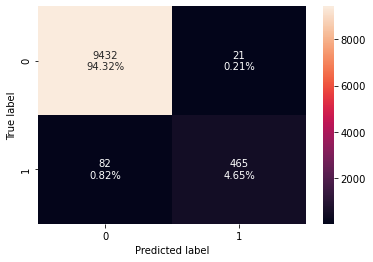

<IPython.core.display.Javascript object>

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(final_model, X_test, y_test)

- The XGBoost tuned model is generalizing well on the test data with a Minimum_Vs_Model_cost of 0.792 (the cross validation training average score was 0.799 and the validation score was 0.821)
- The model is able to make predictions resulting in a maintenance cost ~ (1/0.792 or ~1.26) times the minimum maintenance cost possible

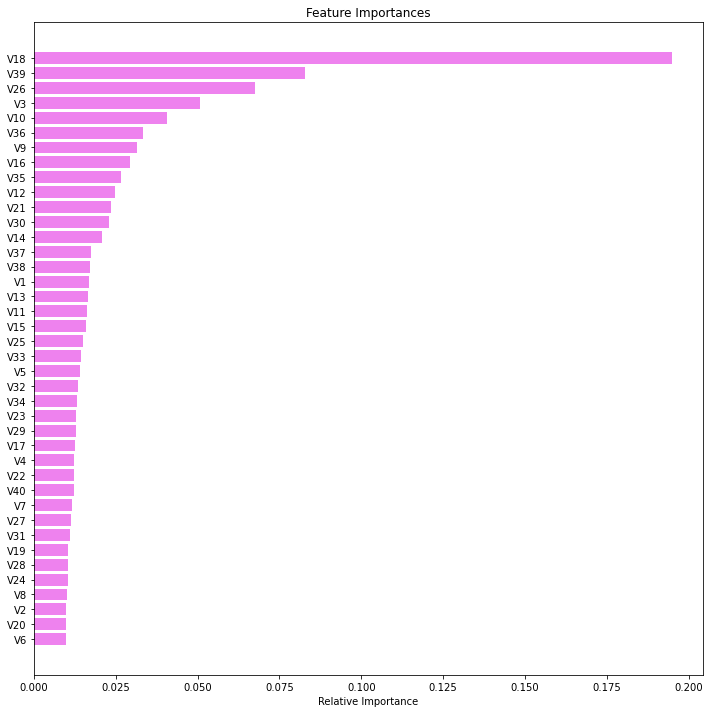

<IPython.core.display.Javascript object>

In [ ]:
feature_names = data.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- The top attributes which have the maximum importance for making accurate failure/ no-failure predictions are "V18", "V39", "V26", "V3" & "V10"

## Pipelines to build the final model

- Pipelines can be used to put the final model in production

In [ ]:
# As we already know the final model, we will not be splitting train set into train and validation sets

X_train_pipeline = train.drop("Target", axis=1)
y_train_pipeline = train["Target"]

<IPython.core.display.Javascript object>

In [ ]:
X_test_pipeline = test.drop("Target", axis=1)
y_test_pipeline = test["Target"]

<IPython.core.display.Javascript object>

In [ ]:
model_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGB",
            XGBClassifier(
                subsample=0.9,
                scale_pos_weight=10,
                n_estimators=250,
                learning_rate=0.1,
                gamma=3,
                random_state=1,
                eval_metric="logloss",
            ),
        ),
    ]
)
# Fit the model on training data
model_pipeline.fit(X_train_pipeline, y_train_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=3, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=250,
                               n_jobs=4, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

<IPython.core.display.Javascript object>

In [ ]:
# transforming and predicting on test data
model_pipeline.predict(X_test_pipeline)

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [ ]:
Minimum_Vs_Model_cost(y_test_pipeline, model_pipeline.predict(X_test_pipeline))

0.7997076023391813

<IPython.core.display.Javascript object>

- The pipeline performance is as expected (Minimum_Vs_Model_cost 0.799) indicating it was built accurately to replicate the final chosen model after necessary pre processing 

# Business Insights and Conclusions

- A machine learning model has been built to minimize the total maintenance cost of machinery/processes used for wind energy production
    - The final tuned model (XGBoost) was chosen after building ~7 different machine learning algorithms & further optimizing for target class imbalance (having few "failures" and many "no failures" in dataset) as well as finetuning the algorithm performance (hyperparameter and cross validation techniques)

    - A pipeline was additionally built to productionise the final chosen model
   
   
- The model is expected to generalize well in terms of predictions & expected to result in a maintenance cost ~1.26 times minimum possible maintenance cost. Having no model in place for predictions could potentially result in costs as high as ~2.67 minimum possible maintenance cost. Hence, productionising the model has a large cost saving advantage

- The main attributes of importance for predicting failures vs. no failures were found to be "V18", "V39", "V26", "V3" & "V10" in order of decreasing importance. This added knowledge can be used to refine the process of collecting more frequent sensor information to be used in improving the machine learning model to further decrease maintenance costs 